# Pipeline for High-z Radio Galaxies 06: Application of full pipeline for prediction with optimised thresholds

## Introduction

In this file, three models will be applied consecutively in order to predict  
the detection of Radio Galaxies (radio AGN) and their redshift.  

In principle, this pipeline should be applied to data in Stripe 82. But  
it can be used with any other suitable dataset.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection, QuadMesh
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.ndimage import gaussian_filter
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import sklearn.pipeline
from scipy import stats
import colorcet as cc
import cmasher as cmr
from pycaret import classification as pyc
from pycaret import regression as pyr
import pandas as pd
import mpl_scatter_density
from joblib import dump, load
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

Functions to predict values

In [4]:
def predict_star(catalog_df, star_model, cal_str_model, threshold, cal_threshold, raw_score=True):
    catalog_df = pyc.predict_model(star_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_1'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    catalog_df.loc[:, 'Score_no_star'] = np.around(catalog_df.loc[:, 'Score_no_star'], decimals=7)
    pred_probs = cal_str_model.predict(catalog_df.loc[:, 'Score_0'])
    cal_class  = np.array(pred_probs < (1 - cal_threshold)).astype(int)
    catalog_df['Prob_no_star']  = pred_probs
    catalog_df['pred_star_cal'] = cal_class
    return catalog_df

In [5]:
def M12_AGN_criterion(catalog_df):
    M12_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 <
                           0.315 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) + 0.791) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           0.315 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) - 0.222) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           -3.172 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) + 7.624)).astype(int)
    return M12_column

In [6]:
def S12_AGN_criterion(catalog_df):
    S12_column = np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >= 0.8).astype(int)
    return S12_column

In [7]:
def M16_AGN_criterion(catalog_df):
    M16_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 > 0.5) &
                  np.array(catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174 < 4.4)).astype(int)
    return M16_column

In [8]:
def B18_AGN_criterion(catalog_df):
    B18_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 > 0.5) &
                  np.array(catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174 > 2.2) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           2 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) - 8.9)).astype(int)
    return B18_column

In [9]:
def C22_AGN_criterion(catalog_df):  # This work
    # C22_column = (np.array(catalog_df.loc[:, 'rmag'] - catalog_df.loc[:, 'zmag'] - 0.617 + 0.866 > -0.45) &
    #               np.array(catalog_df.loc[:, 'rmag'] - catalog_df.loc[:, 'zmag'] - 0.617 + 0.866 < 1.8) &
    #               np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
    #                        0.355 * (catalog_df.loc[:, 'rmag'] - catalog_df.loc[:, 'zmag'] - 0.617 + 0.866) + 0.26)).astype(int)  # W1-W2, r-z
    C22_column = (np.array(catalog_df.loc[:, 'gmag'] - catalog_df.loc[:, 'rmag'] - 0.481 + 0.617 > -0.76) &
                  np.array(catalog_df.loc[:, 'gmag'] - catalog_df.loc[:, 'rmag'] - 0.481 + 0.617 < 1.8) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           0.227 * (catalog_df.loc[:, 'rmag'] - catalog_df.loc[:, 'zmag'] - 0.481 + 0.617) + 0.43)).astype(int)  # W1-W2, g-r
    return C22_column

In [10]:
def add_AGN_criteria(catalog_df):
    catalog_df['M12_AGN'] = M12_AGN_criterion(catalog_df)
    catalog_df['S12_AGN'] = S12_AGN_criterion(catalog_df)
    catalog_df['M16_AGN'] = M16_AGN_criterion(catalog_df)
    catalog_df['B18_AGN'] = B18_AGN_criterion(catalog_df)
    catalog_df['C22_AGN'] = C22_AGN_criterion(catalog_df)
    return catalog_df

In [11]:
def radio_lum(flux, z, alpha):  # Output in W Hz-1
    lum_dist = cosmo.luminosity_distance(z).to(u.m)
    num      = 4 * np.pi * flux.to(u.Jy) * lum_dist**2
    denom    = (1 + z)**(alpha +1)
    return (num/denom).to(u.W / u.Hz)

In [12]:
def cut_rgb_val(val):
    if val < 0.0:
        return 0.0
    if val > 1.0:
        return 1.0
    else:
        return val

In [13]:
def fmt(x):
    x = x * 100.
    x = 100. - x
    s = f'{x:.2f}'
    if s.endswith('0'):
        s = f'{x:.0f}'
    return rf'{s} \%' if plt.rcParams['text.usetex'] else f'{s} %'

In [14]:
def make_borders_zero(matrix):
    matrix[:, 0]  = 0.0
    matrix[:, -1] = 0.0
    matrix[0, :]  = 0.0
    matrix[-1, :] = 0.0
    return matrix

In [15]:
def pad_matrix_zeros(matrix, xedges, yedges):  # Pads matrices and creates centred edges
    x_centres = 0.5 * (xedges[:-1] + xedges[1:])
    y_centres = 0.5 * (yedges[:-1] + yedges[1:])
    matrix    = np.pad(matrix, ((1, 1), (1, 1)), mode='constant', constant_values=(0,))
    x_centres = np.pad(x_centres, (1, 1), mode='constant', constant_values=(xedges[0], xedges[-1]))
    y_centres = np.pad(y_centres, (1, 1), mode='constant', constant_values=(yedges[0], yedges[-1]))
    return matrix, x_centres, y_centres

In [16]:
def clean_and_smooth_matrix(matrix, sigma=0.9):
    matrix[~np.isfinite(matrix)] = 0
    matrix_smooth = gaussian_filter(matrix, sigma=0.9)
    matrix_smooth[~np.isfinite(matrix_smooth)] = 0
    return matrix_smooth

In [17]:
colour_hex_rAGN        = '#D32F2F'
colour_cet_rAGN        = plt.get_cmap('cet_rainbow')(1.0)
colour_rAGN            = mcolors.to_rgba(colour_cet_rAGN)
colour_rAGN_rgb        = mcolors.to_rgb(colour_cet_rAGN)
colour_rAGN_shade      = list(colour_rAGN)
colour_rAGN_shade[3]   = 0.75
colour_rAGN_shade      = tuple(colour_rAGN_shade)
colour_rAGN_rgb_darker = list(colour_rAGN_rgb)
colour_rAGN_rgb_darker = list([value * 0.7 for value in colour_rAGN_rgb_darker])
colour_rAGN_rgb_bright = list([cut_rgb_val(value * 1.5) for value in list(colour_rAGN_rgb)])
colour_rAGN_rgb_darker = tuple(colour_rAGN_rgb_darker)
colour_rAGN_rgb_bright = tuple(colour_rAGN_rgb_bright)
colors_rAGN            = [colour_rAGN_rgb_darker, colour_rAGN_rgb_bright] # first color is darker
cm_gradient_rAGN       = mcolors.LinearSegmentedColormap.from_list('gradient_rAGN', colors_rAGN, N=50)

---

## Reading data

Flags.

In [18]:
save_plot_flag      = False
load_models_flag    = True
use_calibration     = True
compare_A17_flag    = True  # Compare with the results from Ananna et al., 2017
save_indices_flag   = False

In [19]:
used_area           = 'HETDEX'  # can be 'S82', 'HETDEX', 'COSMOS'
HETDEX_subset       = 'Test'  # Validation, Training, Test, Val+Train, 'Calibration'
if used_area != 'HETDEX':
    HETDEX_subset   = ''

In [20]:
if used_area != 'S82':
    compare_A17_flag = False
if used_area != 'HETDEX':
    metrics_hiz_AGN = False

In [21]:
radio_alpha         = -0.7

In [22]:
if used_area == 'HETDEX':
    int_flux_col        = 'Sint_LOFAR'
    limit_flux_survey   = 71e-6 * 1e-3  # mJy
    limit_flux_survey_b = 71e-6  # 25 uJy
    radio_freq          = 150 * u.MHz
if used_area == 'S82':
    int_flux_col        = 'Fint_VLAS82'
    limit_flux_survey   = 52e-6 * 1e-3  # mJy
    limit_flux_survey_b = 52e-6  # 25 uJy
    radio_freq          = 1.4 * u.GHz

In [23]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [24]:
feats_2_disc_S82    = ['RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect']
feats_2_disc_HETDEX = ['RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect']
feats_2_disc_COSMOS = ['RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed', 'radio_detect', ]

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [25]:
full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').drop(columns=features_2_discard)

In [26]:
if used_area == 'S82':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'VLAS82_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['VLAS82_detect'])
if used_area == 'COSMOS':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'COSMOSVLA3_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['COSMOSVLA3_detect'])

Create features with class and combined redshift.

In [27]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
filter_non_confirmed                = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

Create column for detection as Radio AGN

In [28]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
full_catalog_df['radio_SFG']        = np.array(full_catalog_df.loc[:, 'is_gal'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)

Show early statistics of confirmed sources

In [29]:
print(f'In the {used_area} field, there are {np.sum(full_catalog_df.loc[:, "class"] != 0.5):,} confirmed sources.')
print(f'{np.sum(full_catalog_df.loc[:, "class"] == 0):,} of them are galaxies.')
print(f'{np.sum(full_catalog_df.loc[:, "class"] == 1):,} of them are AGN.')
print(f'{np.sum(full_catalog_df.loc[:, "class"] == 2):,} of them are stars.')

In the HETDEX field, there are 118,734 confirmed sources.
68,196 of them are galaxies.
50,538 of them are AGN.
0 of them are stars.


---

Split dataset if from HETDEX

In [30]:
if used_area == 'HETDEX':
    filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
    unknown_cat_df    = full_catalog_df.loc[~filter_known_spec]
    full_catalog_df   = full_catalog_df.loc[filter_known_spec]
    train_val_df, train_df, validation_df, calibration_df, test_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=use_calibration)
    # Save indices of sources per sub-set
    if save_indices_flag:
        idx_train_val   = train_val_df.index.to_numpy()
        idx_train       = train_df.index.to_numpy()
        idx_validation  = validation_df.index.to_numpy()
        idx_calibration = calibration_df.index.to_numpy()
        idx_test        = test_df.index.to_numpy()
        
        np.savetxt(gv.indices_path + 'indices_train_val.txt',   idx_train_val,   fmt='%d')
        np.savetxt(gv.indices_path + 'indices_train.txt',       idx_train,       fmt='%d')
        np.savetxt(gv.indices_path + 'indices_validation.txt',  idx_validation,  fmt='%d')
        np.savetxt(gv.indices_path + 'indices_calibration.txt', idx_calibration, fmt='%d')
        np.savetxt(gv.indices_path + 'indices_test.txt',        idx_test,        fmt='%d')
    
    print('Shape of used data in HETDEX')
    print('-' * 65)
    print(f'Full confirmed dataset size                           : {full_catalog_df.shape}')
    print(f'Data for Modeling (Train, Validation, and Calibration): {train_val_df.shape}')
    print(f'Training data                                         : {train_df.shape}')
    print(f'Validation data                                       : {validation_df.shape}')
    print(f'Calibration data                                      : {calibration_df.shape}')
    print(f'Testing data                                          : {test_df.shape}')
    print('-' * 65)
    print()
    print(f'Using {HETDEX_subset} data from HETDEX')
    selected_dataset = {'Training': train_df, 'Test': test_df, 'Val+Train': train_val_df,
                        'Validation': validation_df, 'Calibration': calibration_df}
    known_catalog_df = selected_dataset[HETDEX_subset]

Shape of used data in HETDEX
-----------------------------------------------------------------
Full confirmed dataset size                           : (118734, 103)
Data for Modeling (Train, Validation, and Calibration): (94987, 103)
Training data                                         : (75989, 103)
Validation data                                       : (9499, 103)
Calibration data                                      : (9499, 103)
Testing data                                          : (23747, 103)
-----------------------------------------------------------------

Using Test data from HETDEX


Split data if not from HETDEX

In [31]:
if used_area != 'HETDEX':
    # filter_confirmed = (full_catalog_df.loc[:, 'class'] == 0) |\
    #                    (full_catalog_df.loc[:, 'class'] == 1) |\
    #                    (full_catalog_df.loc[:, 'class'] == 2)  # Galaxy, AGN, star
    filter_confirmed  = (full_catalog_df.loc[:, 'class'] == 0) |\
                        (full_catalog_df.loc[:, 'class'] == 1) # Galaxy, AGN
    unknown_cat_df    = full_catalog_df.loc[~filter_confirmed]
    known_catalog_df  = full_catalog_df.loc[filter_confirmed]

In [32]:
all_subsets_dfs      = [known_catalog_df, unknown_cat_df]

In [33]:
print(f'Full used dataset size:              {known_catalog_df.shape}')
print('-' * 50)
print(f'Thus, it has {known_catalog_df.shape[0]:,} sources and {known_catalog_df.shape[1]:,} features.')

Full used dataset size:              (23747, 103)
--------------------------------------------------
Thus, it has 23,747 sources and 103 features.


Discard minor features.

In [34]:
full_catalog_df                     = known_catalog_df.drop(columns=['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'zsp', 'spCl'])

---

### Load models

In [35]:
if load_models_flag:
    AGN_SFG_clf           = pyc.load_model(gv.models_path + gv.AGN_gal_model)  #  AGN/galaxy
    cal_AGN_SFG_clf       = load(gv.models_path + gv.cal_AGN_gal_model)  # AGN/galaxy calibrated model
    radio_det_AGN_clf     = pyc.load_model(gv.models_path + gv.radio_model)  # Radio detection for AGN
    cal_radio_det_AGN_clf = load(gv.models_path + gv.cal_radio_model)  # calibrated model radio detection for AGN
    
    radio_det_SFG_clf     = pyc.load_model(gv.models_path + gv.radio_galaxies_model)  # Radio detection for galaxies
    cal_radio_det_SFG_clf = load(gv.models_path + gv.cal_radio_gals_model)  # calibrated model radio detection for galaxie
    
    redshift_reg_rAGN     = pyr.load_model(gv.models_path + gv.full_z_model)  # Redshift prediction for radio-AGN
    redshift_reg_rSFG     = pyr.load_model(gv.models_path + gv.z_radio_galaxies_model)  # Redshift prediction for radio-galaxies

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


Predictions with optimised thresholds.

In [36]:
threshold_AGN_logit      = np.log(gv.cal_AGN_thresh   / (1 - gv.cal_AGN_thresh))
threshold_radio_logit    = np.log(gv.cal_radio_thresh / (1 - gv.cal_radio_thresh))

In [37]:
if load_models_flag:
    print(f'Predicting AGN/SFG in {HETDEX_subset} dataset')
    known_catalog_df = gf.predict_AGN_gal(known_catalog_df, AGN_SFG_clf,  cal_AGN_SFG_clf,
                                          gv.AGN_thresh, gv.cal_AGN_thresh, raw_score=True,
                                          cols_out=['pred_class', 'Score_AGN', 'Prob_AGN', 'pred_class_cal'])

Predicting AGN/SFG in Test dataset


In [38]:
if load_models_flag:
    print(f'Predicting rAGN in {HETDEX_subset} dataset')
    known_catalog_df = gf.predict_radio_det(known_catalog_df, radio_det_AGN_clf, cal_radio_det_AGN_clf,
                                            gv.radio_thresh, gv.cal_radio_thresh, raw_score=True,
                                            cols_out=['pred_radio_AGN', 'Score_radio_AGN', 'Prob_radio_AGN', 'pred_radio_AGN_cal'])

Predicting rAGN in Test dataset


In [39]:
if load_models_flag:
    print(f'Predicting rSFG in {HETDEX_subset} dataset')
    known_catalog_df = gf.predict_radio_det(known_catalog_df, radio_det_SFG_clf, cal_radio_det_SFG_clf,
                                            gv.radio_gals_thresh, gv.cal_radio_gals_thresh, raw_score=True,
                                            cols_out=['pred_radio_SFG', 'Score_radio_SFG', 'Prob_radio_SFG', 'pred_radio_SFG_cal'])

Predicting rSFG in Test dataset


In [40]:
if load_models_flag:
    print(f'Predicting redshift for rAGN in {HETDEX_subset} dataset')
    known_catalog_df = gf.predict_z(known_catalog_df, redshift_reg_rAGN, cols_out=['pred_Z_rAGN'])

Predicting redshift for rAGN in Test dataset


In [41]:
if load_models_flag:
    print(f'Predicting redshift for rSFG in {HETDEX_subset} dataset')
    known_catalog_df = gf.predict_z(known_catalog_df, redshift_reg_rSFG, cols_out=['pred_Z_rSFG'])

Predicting redshift for rSFG in Test dataset


In [42]:
known_catalog_df.loc[:, 'pred_rAGN_cal'] = (np.array(known_catalog_df.loc[:, 'pred_class_cal'] == 1) & np.array(known_catalog_df.loc[:, 'pred_radio_AGN_cal'] == 1)).astype(int)
known_catalog_df.loc[:, 'pred_rSFG_cal'] = (np.array(known_catalog_df.loc[:, 'pred_class_cal'] == 0) & np.array(known_catalog_df.loc[:, 'pred_radio_SFG_cal'] == 1)).astype(int)

In [43]:
known_catalog_df.loc[:, 'class_SFG']          = 1 - known_catalog_df.loc[:, 'class']
known_catalog_df.loc[:, 'pred_class_SFG_cal'] = 1 - known_catalog_df.loc[:, 'pred_class_cal']

In [44]:
all_subsets_dfs      = [known_catalog_df, unknown_cat_df]

##### Include AGN detection criteria from literature

In [45]:
known_catalog_df = add_AGN_criteria(known_catalog_df)
known_catalog_df = add_AGN_criteria(known_catalog_df)

#### Only metrics for known sources predicted with calibrated models

In [46]:
filt_true_radio = np.array(known_catalog_df.loc[:, 'LOFAR_detect'] == 1)

In [47]:
filt_true_AGN   = np.array(known_catalog_df.loc[:, 'class'] == 1)
filt_true_SFG   = np.array(known_catalog_df.loc[:, 'class'] == 0)
filt_true_rAGN  = filt_true_AGN & filt_true_radio
filt_true_rSFG  = filt_true_SFG & filt_true_radio

In [48]:
filt_pred_radio_AGN = np.array(known_catalog_df.loc[:, 'pred_radio_AGN_cal'] == 1)
filt_pred_radio_SFG = np.array(known_catalog_df.loc[:, 'pred_radio_SFG_cal'] == 1)

In [49]:
filt_pred_AGN   = np.array(known_catalog_df.loc[:, 'pred_class_cal'] == 1)
filt_pred_SFG   = np.array(known_catalog_df.loc[:, 'pred_class_cal'] == 0)
filt_pred_rAGN  = filt_pred_AGN & filt_pred_radio_AGN
filt_pred_rSFG  = filt_pred_SFG & filt_pred_radio_SFG

In [50]:
filt_TP_rAGN    = filt_true_rAGN & filt_pred_rAGN
filt_TP_rSFG    = filt_true_rSFG & filt_pred_rSFG

In [51]:
filt_good_true_z = np.array(known_catalog_df.loc[:, 'Z'] > 0)

In [52]:
cm_AGN        = gf.conf_mat_func(known_catalog_df.loc[:, 'class'],
                                 known_catalog_df.loc[:, 'pred_class_cal'])
cm_AGN_random = gf.conf_mat_random(known_catalog_df.loc[:, 'class'])

cm_gal        = np.rot90(cm_AGN, k=2)
cm_gal_random = np.rot90(cm_AGN_random, k=2)

In [53]:
print(cm_AGN)
print()
print(cm_AGN_random)
print()
print(cm_gal)
print()
print(cm_gal_random)

[[13072   567]
 [  383  9725]]

[[7834 5805]
 [5805 4303]]

[[ 9725   383]
 [  567 13072]]

[[4303 5805]
 [5805 7834]]


In [54]:
cm_r_in_pred_AGN        = gf.conf_mat_func(known_catalog_df.loc[filt_pred_AGN, 'LOFAR_detect'],
                                           known_catalog_df.loc[filt_pred_AGN, 'pred_radio_AGN_cal'])
cm_r_in_true_AGN        = gf.conf_mat_func(known_catalog_df.loc[filt_true_AGN, 'LOFAR_detect'],
                                           known_catalog_df.loc[filt_true_AGN, 'pred_radio_AGN_cal'])
cm_r_in_pred_AGN_random = gf.conf_mat_random(known_catalog_df.loc[filt_pred_AGN, 'LOFAR_detect'])
cm_r_in_true_AGN_random = gf.conf_mat_random(known_catalog_df.loc[filt_true_AGN, 'LOFAR_detect'])

cm_r_in_pred_gal        = gf.conf_mat_func(known_catalog_df.loc[filt_pred_SFG, 'LOFAR_detect'],
                                           known_catalog_df.loc[filt_pred_SFG, 'pred_radio_SFG_cal'])
cm_r_in_true_gal        = gf.conf_mat_func(known_catalog_df.loc[filt_true_SFG, 'LOFAR_detect'],
                                           known_catalog_df.loc[filt_true_SFG, 'pred_radio_SFG_cal'])
cm_r_in_pred_gal_random = gf.conf_mat_random(known_catalog_df.loc[filt_pred_SFG, 'LOFAR_detect'])
cm_r_in_true_gal_random = gf.conf_mat_random(known_catalog_df.loc[filt_true_SFG, 'LOFAR_detect'])

In [55]:
print(cm_r_in_pred_AGN)
print()
print(cm_r_in_true_AGN)
print()
print(cm_r_in_pred_AGN_random)
print()
print(cm_r_in_true_AGN_random)
print()
print(cm_r_in_pred_gal)
print()
print(cm_r_in_true_gal)
print()
print(cm_r_in_pred_gal_random)
print()
print(cm_r_in_true_gal_random)

[[7666 1030]
 [ 843  753]]

[[7367 1077]
 [ 841  823]]

[[7347 1349]
 [1349  247]]

[[7054 1390]
 [1390  274]]

[[10321  1062]
 [ 1129   943]]

[[10566  1069]
 [ 1089   915]]

[[9630 1753]
 [1753  319]]

[[9925 1710]
 [1710  294]]


In [56]:
cm_rAGN        = gf.conf_mat_func(known_catalog_df.loc[filt_pred_AGN, 'radio_AGN'],
                                  known_catalog_df.loc[filt_pred_AGN, 'pred_rAGN_cal'])
cm_rAGN_random = gf.conf_mat_random(known_catalog_df.loc[filt_pred_AGN, 'radio_AGN'])

cm_rGal        = gf.conf_mat_func(known_catalog_df.loc[filt_pred_SFG, 'radio_SFG'],
                                  known_catalog_df.loc[filt_pred_SFG, 'pred_rSFG_cal'])
cm_rGal_random = gf.conf_mat_random(known_catalog_df.loc[filt_pred_SFG, 'radio_SFG'])

In [57]:
print(cm_rAGN)
print()
print(cm_rAGN_random)
print()
print(cm_rGal)
print()
print(cm_rGal_random)

[[7692 1093]
 [ 817  690]]

[[7499 1286]
 [1286  221]]

[[10382  1158]
 [ 1068   847]]

[[9898 1642]
 [1642  273]]


Confusion matrices from literature AGN criteria.

In [58]:
cm_AGN_S12 = gf.conf_mat_func(known_catalog_df.loc[:, 'class'],
                              known_catalog_df.loc[:, 'S12_AGN'])
cm_AGN_M12 = gf.conf_mat_func(known_catalog_df.loc[:, 'class'],
                              known_catalog_df.loc[:, 'M12_AGN'])
cm_AGN_M16 = gf.conf_mat_func(known_catalog_df.loc[:, 'class'],
                              known_catalog_df.loc[:, 'M16_AGN'])
cm_AGN_B18 = gf.conf_mat_func(known_catalog_df.loc[:, 'class'],
                              known_catalog_df.loc[:, 'B18_AGN'])
cm_AGN_C22 = gf.conf_mat_func(known_catalog_df.loc[:, 'class'],
                              known_catalog_df.loc[:, 'C22_AGN'])

cm_gal_S12 = np.rot90(cm_AGN_S12, k=2)
cm_gal_M12 = np.rot90(cm_AGN_M12, k=2)
cm_gal_M16 = np.rot90(cm_AGN_M16, k=2)
cm_gal_B18 = np.rot90(cm_AGN_B18, k=2)
cm_gal_C22 = np.rot90(cm_AGN_C22, k=2)

In [59]:
print(cm_AGN_S12)
print()
print(cm_AGN_M12)
print()
print(cm_AGN_M16)
print()
print(cm_AGN_B18)
print()
print(cm_AGN_C22)

[[13118   521]
 [ 1970  8138]]

[[13596    43]
 [ 6350  3758]]

[[13499   140]
 [ 4702  5406]]

[[13454   185]
 [ 2764  7344]]

[[13048   591]
 [  842  9266]]


In [60]:
print(cm_gal_S12)
print()
print(cm_gal_M12)
print()
print(cm_gal_M16)
print()
print(cm_gal_B18)
print()
print(cm_gal_C22)

[[ 8138  1970]
 [  521 13118]]

[[ 3758  6350]
 [   43 13596]]

[[ 5406  4702]
 [  140 13499]]

[[ 7344  2764]
 [  185 13454]]

[[ 9266   842]
 [  591 13048]]


Metrics from confusion matrices

In [61]:
MCC_AGN              = gf.MCC_from_CM(cm_AGN)
Fb_AGN               = gf.Fb_from_CM(cm_AGN)
Precision_AGN        = gf.Precision_from_CM(cm_AGN)
Recall_AGN           = gf.Recall_from_CM(cm_AGN)
ACC_AGN              = gf.ACC_from_CM(cm_AGN)

MCC_AGN_random       = gf.MCC_from_CM(cm_AGN_random)
ACC_AGN_random       = gf.ACC_from_CM(cm_AGN_random)
Fb_AGN_random        = gf.Fb_from_CM(cm_AGN_random)
Precision_AGN_random = gf.Precision_from_CM(cm_AGN_random)
Recall_AGN_random    = gf.Recall_from_CM(cm_AGN_random)

In [62]:
MCC_r_in_pred_AGN              = gf.MCC_from_CM(cm_r_in_pred_AGN)
Fb_r_in_pred_AGN               = gf.Fb_from_CM(cm_r_in_pred_AGN)
Precision_r_in_pred_AGN        = gf.Precision_from_CM(cm_r_in_pred_AGN)
Recall_r_in_pred_AGN           = gf.Recall_from_CM(cm_r_in_pred_AGN)
ACC_r_in_pred_AGN              = gf.ACC_from_CM(cm_r_in_pred_AGN)

MCC_r_in_true_AGN              = gf.MCC_from_CM(cm_r_in_true_AGN)
Fb_r_in_true_AGN               = gf.Fb_from_CM(cm_r_in_true_AGN)
Precision_r_in_true_AGN        = gf.Precision_from_CM(cm_r_in_true_AGN)
Recall_r_in_true_AGN           = gf.Recall_from_CM(cm_r_in_true_AGN)
ACC_r_in_true_AGN              = gf.ACC_from_CM(cm_r_in_true_AGN)

MCC_r_in_pred_AGN_random       = gf.MCC_from_CM(cm_r_in_pred_AGN_random)
ACC_r_in_pred_AGN_random       = gf.ACC_from_CM(cm_r_in_pred_AGN_random)
Fb_r_in_pred_AGN_random        = gf.Fb_from_CM(cm_r_in_pred_AGN_random)
Precision_r_in_pred_AGN_random = gf.Precision_from_CM(cm_r_in_pred_AGN_random)
Recall_r_in_pred_AGN_random    = gf.Recall_from_CM(cm_r_in_pred_AGN_random)

MCC_r_in_true_AGN_random       = gf.MCC_from_CM(cm_r_in_true_AGN_random)
ACC_r_in_true_AGN_random       = gf.ACC_from_CM(cm_r_in_true_AGN_random)
Fb_r_in_true_AGN_random        = gf.Fb_from_CM(cm_r_in_true_AGN_random)
Precision_r_in_true_AGN_random = gf.Precision_from_CM(cm_r_in_true_AGN_random)
Recall_r_in_true_AGN_random    = gf.Recall_from_CM(cm_r_in_true_AGN_random)

In [63]:
MCC_rAGN              = gf.MCC_from_CM(cm_rAGN)
Fb_rAGN               = gf.Fb_from_CM(cm_rAGN)
Precision_rAGN        = gf.Precision_from_CM(cm_rAGN)
Recall_rAGN           = gf.Recall_from_CM(cm_rAGN)
ACC_rAGN              = gf.ACC_from_CM(cm_rAGN)

MCC_rAGN_random       = gf.MCC_from_CM(cm_rAGN_random)
ACC_rAGN_random       = gf.ACC_from_CM(cm_rAGN_random)
Fb_rAGN_random        = gf.Fb_from_CM(cm_rAGN_random)
Precision_rAGN_random = gf.Precision_from_CM(cm_rAGN_random)
Recall_rAGN_random    = gf.Recall_from_CM(cm_rAGN_random)

In [64]:
MCC_gal              = gf.MCC_from_CM(cm_gal)
Fb_gal               = gf.Fb_from_CM(cm_gal)
Precision_gal        = gf.Precision_from_CM(cm_gal)
Recall_gal           = gf.Recall_from_CM(cm_gal)
ACC_gal              = gf.ACC_from_CM(cm_gal)

MCC_gal_random       = gf.MCC_from_CM(cm_gal_random)
ACC_gal_random       = gf.ACC_from_CM(cm_gal_random)
Fb_gal_random        = gf.Fb_from_CM(cm_gal_random)
Precision_gal_random = gf.Precision_from_CM(cm_gal_random)
Recall_gal_random    = gf.Recall_from_CM(cm_gal_random)

In [65]:
MCC_r_in_pred_gal              = gf.MCC_from_CM(cm_r_in_pred_gal)
Fb_r_in_pred_gal               = gf.Fb_from_CM(cm_r_in_pred_gal)
Precision_r_in_pred_gal        = gf.Precision_from_CM(cm_r_in_pred_gal)
Recall_r_in_pred_gal           = gf.Recall_from_CM(cm_r_in_pred_gal)
ACC_r_in_pred_gal              = gf.ACC_from_CM(cm_r_in_pred_gal)

MCC_r_in_true_gal              = gf.MCC_from_CM(cm_r_in_true_gal)
Fb_r_in_true_gal               = gf.Fb_from_CM(cm_r_in_true_gal)
Precision_r_in_true_gal        = gf.Precision_from_CM(cm_r_in_true_gal)
Recall_r_in_true_gal           = gf.Recall_from_CM(cm_r_in_true_gal)
ACC_r_in_true_gal              = gf.ACC_from_CM(cm_r_in_true_gal)

MCC_r_in_pred_gal_random       = gf.MCC_from_CM(cm_r_in_pred_gal_random)
ACC_r_in_pred_gal_random       = gf.ACC_from_CM(cm_r_in_pred_gal_random)
Fb_r_in_pred_gal_random        = gf.Fb_from_CM(cm_r_in_pred_gal_random)
Precision_r_in_pred_gal_random = gf.Precision_from_CM(cm_r_in_pred_gal_random)
Recall_r_in_pred_gal_random    = gf.Recall_from_CM(cm_r_in_pred_gal_random)

MCC_r_in_true_gal_random       = gf.MCC_from_CM(cm_r_in_true_gal_random)
ACC_r_in_true_gal_random       = gf.ACC_from_CM(cm_r_in_true_gal_random)
Fb_r_in_true_gal_random        = gf.Fb_from_CM(cm_r_in_true_gal_random)
Precision_r_in_true_gal_random = gf.Precision_from_CM(cm_r_in_true_gal_random)
Recall_r_in_true_gal_random    = gf.Recall_from_CM(cm_r_in_true_gal_random)

In [66]:
MCC_rGal              = gf.MCC_from_CM(cm_rGal)
Fb_rGal               = gf.Fb_from_CM(cm_rGal)
Precision_rGal        = gf.Precision_from_CM(cm_rGal)
Recall_rGal           = gf.Recall_from_CM(cm_rGal)
ACC_rGal              = gf.ACC_from_CM(cm_rGal)

MCC_rGal_random       = gf.MCC_from_CM(cm_rGal_random)
ACC_rGal_random       = gf.ACC_from_CM(cm_rGal_random)
Fb_rGal_random        = gf.Fb_from_CM(cm_rGal_random)
Precision_rGal_random = gf.Precision_from_CM(cm_rGal_random)
Recall_rGal_random    = gf.Recall_from_CM(cm_rGal_random)

Confusion matrices for AGN criteria from literature

In [67]:
MCC_AGN_S12          = gf.MCC_from_CM(cm_AGN_S12)
ACC_AGN_S12          = gf.ACC_from_CM(cm_AGN_S12)
Fb_AGN_S12           = gf.Fb_from_CM(cm_AGN_S12)
Precision_AGN_S12    = gf.Precision_from_CM(cm_AGN_S12)
Recall_AGN_S12       = gf.Recall_from_CM(cm_AGN_S12)

MCC_AGN_M12          = gf.MCC_from_CM(cm_AGN_M12)
ACC_AGN_M12          = gf.ACC_from_CM(cm_AGN_M12)
Fb_AGN_M12           = gf.Fb_from_CM(cm_AGN_M12)
Precision_AGN_M12    = gf.Precision_from_CM(cm_AGN_M12)
Recall_AGN_M12       = gf.Recall_from_CM(cm_AGN_M12)

MCC_AGN_M16          = gf.MCC_from_CM(cm_AGN_M16)
ACC_AGN_M16          = gf.ACC_from_CM(cm_AGN_M16)
Fb_AGN_M16           = gf.Fb_from_CM(cm_AGN_M16)
Precision_AGN_M16    = gf.Precision_from_CM(cm_AGN_M16)
Recall_AGN_M16       = gf.Recall_from_CM(cm_AGN_M16)

MCC_AGN_B18          = gf.MCC_from_CM(cm_AGN_B18)
ACC_AGN_B18          = gf.ACC_from_CM(cm_AGN_B18)
Fb_AGN_B18           = gf.Fb_from_CM(cm_AGN_B18)
Precision_AGN_B18    = gf.Precision_from_CM(cm_AGN_B18)
Recall_AGN_B18       = gf.Recall_from_CM(cm_AGN_B18)

MCC_AGN_C22          = gf.MCC_from_CM(cm_AGN_C22)
ACC_AGN_C22          = gf.ACC_from_CM(cm_AGN_C22)
Fb_AGN_C22           = gf.Fb_from_CM(cm_AGN_C22)
Precision_AGN_C22    = gf.Precision_from_CM(cm_AGN_C22)
Recall_AGN_C22       = gf.Recall_from_CM(cm_AGN_C22)

metrics_AGN_criteria    = np.array([[Fb_AGN_S12,        Fb_AGN_M12,        Fb_AGN_M16,        Fb_AGN_B18,        Fb_AGN_C22],\
                                    [MCC_AGN_S12,       MCC_AGN_M12,       MCC_AGN_M16,       MCC_AGN_B18,       MCC_AGN_C22],\
                                    [Precision_AGN_S12, Precision_AGN_M12, Precision_AGN_M16, Precision_AGN_B18, Precision_AGN_C22],\
                                    [Recall_AGN_S12,    Recall_AGN_M12,    Recall_AGN_M16,    Recall_AGN_B18,    Recall_AGN_C22],\
                                    [ACC_AGN_S12,       ACC_AGN_M12,       ACC_AGN_M16,       ACC_AGN_B18,       ACC_AGN_C22]]) 

metrics_AGN_criteria_df = pd.DataFrame(data=metrics_AGN_criteria.T, columns=['F-\u03B2', 'MCC', 'Precision', 'Recall', 'Accuracy'],\
                                       index=['S12', 'M12', 'M16', 'B18', 'C22'])

Metrics from redshift predictions

In [68]:
sigma_mad_in_pred_rAGN    = gf.sigma_mad(known_catalog_df.loc[filt_pred_rAGN, 'Z'],    known_catalog_df.loc[filt_pred_rAGN, 'pred_Z_rAGN'])
sigma_nmad_in_pred_rAGN   = gf.sigma_nmad(known_catalog_df.loc[filt_pred_rAGN, 'Z'],   known_catalog_df.loc[filt_pred_rAGN, 'pred_Z_rAGN'])
sigma_z_in_pred_rAGN      = gf.sigma_z(known_catalog_df.loc[filt_pred_rAGN, 'Z'],      known_catalog_df.loc[filt_pred_rAGN, 'pred_Z_rAGN'])
sigma_z_norm_in_pred_rAGN = gf.sigma_z_norm(known_catalog_df.loc[filt_pred_rAGN, 'Z'], known_catalog_df.loc[filt_pred_rAGN, 'pred_Z_rAGN'])
out_frac_in_pred_rAGN     = gf.outlier_frac(known_catalog_df.loc[filt_pred_rAGN, 'Z'], known_catalog_df.loc[filt_pred_rAGN, 'pred_Z_rAGN'])

sigma_mad_in_true_rAGN    = gf.sigma_mad(known_catalog_df.loc[filt_true_rAGN, 'Z'],    known_catalog_df.loc[filt_true_rAGN, 'pred_Z_rAGN'])
sigma_nmad_in_true_rAGN   = gf.sigma_nmad(known_catalog_df.loc[filt_true_rAGN, 'Z'],   known_catalog_df.loc[filt_true_rAGN, 'pred_Z_rAGN'])
sigma_z_in_true_rAGN      = gf.sigma_z(known_catalog_df.loc[filt_true_rAGN, 'Z'],      known_catalog_df.loc[filt_true_rAGN, 'pred_Z_rAGN'])
sigma_z_norm_in_true_rAGN = gf.sigma_z_norm(known_catalog_df.loc[filt_true_rAGN, 'Z'], known_catalog_df.loc[filt_true_rAGN, 'pred_Z_rAGN'])
out_frac_in_true_rAGN     = gf.outlier_frac(known_catalog_df.loc[filt_true_rAGN, 'Z'], known_catalog_df.loc[filt_true_rAGN, 'pred_Z_rAGN'])

sigma_mad_in_TP_rAGN      = gf.sigma_mad(known_catalog_df.loc[filt_TP_rAGN, 'Z'],      known_catalog_df.loc[filt_TP_rAGN, 'pred_Z_rAGN'])
sigma_nmad_in_TP_rAGN     = gf.sigma_nmad(known_catalog_df.loc[filt_TP_rAGN, 'Z'],     known_catalog_df.loc[filt_TP_rAGN, 'pred_Z_rAGN'])
sigma_z_in_TP_rAGN        = gf.sigma_z(known_catalog_df.loc[filt_TP_rAGN, 'Z'],        known_catalog_df.loc[filt_TP_rAGN, 'pred_Z_rAGN'])
sigma_z_norm_in_TP_rAGN   = gf.sigma_z_norm(known_catalog_df.loc[filt_TP_rAGN, 'Z'],   known_catalog_df.loc[filt_TP_rAGN, 'pred_Z_rAGN'])
out_frac_in_TP_rAGN       = gf.outlier_frac(known_catalog_df.loc[filt_TP_rAGN, 'Z'],   known_catalog_df.loc[filt_TP_rAGN, 'pred_Z_rAGN'])

In [69]:
sigma_mad_in_pred_rSFG    = gf.sigma_mad(known_catalog_df.loc[filt_pred_rSFG, 'Z'],    known_catalog_df.loc[filt_pred_rSFG, 'pred_Z_rSFG'])
sigma_nmad_in_pred_rSFG   = gf.sigma_nmad(known_catalog_df.loc[filt_pred_rSFG, 'Z'],   known_catalog_df.loc[filt_pred_rSFG, 'pred_Z_rSFG'])
sigma_z_in_pred_rSFG      = gf.sigma_z(known_catalog_df.loc[filt_pred_rSFG, 'Z'],      known_catalog_df.loc[filt_pred_rSFG, 'pred_Z_rSFG'])
sigma_z_norm_in_pred_rSFG = gf.sigma_z_norm(known_catalog_df.loc[filt_pred_rSFG, 'Z'], known_catalog_df.loc[filt_pred_rSFG, 'pred_Z_rSFG'])
out_frac_in_pred_rSFG     = gf.outlier_frac(known_catalog_df.loc[filt_pred_rSFG, 'Z'], known_catalog_df.loc[filt_pred_rSFG, 'pred_Z_rSFG'])

sigma_mad_in_true_rSFG    = gf.sigma_mad(known_catalog_df.loc[filt_true_rSFG, 'Z'],    known_catalog_df.loc[filt_true_rSFG, 'pred_Z_rSFG'])
sigma_nmad_in_true_rSFG   = gf.sigma_nmad(known_catalog_df.loc[filt_true_rSFG, 'Z'],   known_catalog_df.loc[filt_true_rSFG, 'pred_Z_rSFG'])
sigma_z_in_true_rSFG      = gf.sigma_z(known_catalog_df.loc[filt_true_rSFG, 'Z'],      known_catalog_df.loc[filt_true_rSFG, 'pred_Z_rSFG'])
sigma_z_norm_in_true_rSFG = gf.sigma_z_norm(known_catalog_df.loc[filt_true_rSFG, 'Z'], known_catalog_df.loc[filt_true_rSFG, 'pred_Z_rSFG'])
out_frac_in_true_rSFG     = gf.outlier_frac(known_catalog_df.loc[filt_true_rSFG, 'Z'], known_catalog_df.loc[filt_true_rSFG, 'pred_Z_rSFG'])

sigma_mad_in_TP_rSFG      = gf.sigma_mad(known_catalog_df.loc[filt_TP_rSFG, 'Z'],      known_catalog_df.loc[filt_TP_rSFG, 'pred_Z_rSFG'])
sigma_nmad_in_TP_rSFG     = gf.sigma_nmad(known_catalog_df.loc[filt_TP_rSFG, 'Z'],     known_catalog_df.loc[filt_TP_rSFG, 'pred_Z_rSFG'])
sigma_z_in_TP_rSFG        = gf.sigma_z(known_catalog_df.loc[filt_TP_rSFG, 'Z'],        known_catalog_df.loc[filt_TP_rSFG, 'pred_Z_rSFG'])
sigma_z_norm_in_TP_rSFG   = gf.sigma_z_norm(known_catalog_df.loc[filt_TP_rSFG, 'Z'],   known_catalog_df.loc[filt_TP_rSFG, 'pred_Z_rSFG'])
out_frac_in_TP_rSFG       = gf.outlier_frac(known_catalog_df.loc[filt_TP_rSFG, 'Z'],   known_catalog_df.loc[filt_TP_rSFG, 'pred_Z_rSFG'])

Obtain uncertainties from CV

In [70]:
subsets_clf_filt    = [np.array([True] * len(known_catalog_df)), np.array([True] * len(known_catalog_df)),
                       filt_true_AGN, filt_pred_AGN, filt_true_SFG, filt_pred_SFG,
                       np.array([True] * len(known_catalog_df)), np.array([True] * len(known_catalog_df))]
subsets_reg_filt    = [filt_true_rAGN, filt_pred_rAGN, filt_TP_rAGN, filt_true_rSFG, filt_pred_rSFG, filt_TP_rSFG]

In [71]:
subsets_clf_names  = ['AGN', 'SFG', 'Radio in true AGN', 'Radio in pred AGN',
                      'Radio in true SFG', 'Radio in pred SFG', 'Radio AGN', 'Radio SFG']
subsets_reg_names  = ['Redshift in true rAGN', 'Redshift in pred rAGN', 'Redshift in TP rAGN',
                      'Redshift in true rSFG', 'Redshift in pred rSFG', 'Redshift in TP rSFG']

In [72]:
true_classes_clf   = ['class', 'class_SFG',
                      'LOFAR_detect', 'LOFAR_detect', 'LOFAR_detect', 'LOFAR_detect',
                      'radio_AGN', 'radio_SFG']
pred_classes_clf   = ['pred_class_cal', 'pred_class_SFG_cal', 'pred_radio_AGN_cal',
                      'pred_radio_AGN_cal', 'pred_radio_SFG_cal', 'pred_radio_SFG_cal',
                      'pred_rAGN_cal', 'pred_rSFG_cal']
true_target_reg    = ['Z', 'Z', 'Z', 'Z', 'Z', 'Z']
pred_target_reg    = ['pred_Z_rAGN', 'pred_Z_rAGN', 'pred_Z_rAGN', 'pred_Z_rSFG', 'pred_Z_rSFG', 'pred_Z_rSFG']

In [73]:
clf_scores_names   = ['F-\u03B2', 'MCC', 'Precision', 'Recall']
reg_scores_names   = ['\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7']

In [74]:
CV_object_clf      = StratifiedKFold(n_splits=10, random_state=gv.seed, shuffle=True)
CV_object_reg      = KFold(n_splits=10, random_state=gv.seed, shuffle=True)

In [75]:
cv_scores_clf      = {}
cv_scores_mean_clf = {}
cv_scores_std_clf  = {}

In [76]:
cv_scores_reg      = {}
cv_scores_mean_reg = {}
cv_scores_std_reg  = {}

In [77]:
for count, (subset_filter, subset_name) in enumerate(zip(subsets_clf_filt, subsets_clf_names)):
    tmp_f_betas = []
    tmp_mccs    = []
    tmp_precs   = []
    tmp_recalls = []
    for _, fold_index in iter(CV_object_clf.split(known_catalog_df.loc[subset_filter,
                                                  pred_classes_clf[count]],
                                                  known_catalog_df.loc[subset_filter, true_classes_clf[count]])):
        tmp_cm     = gf.conf_mat_func(known_catalog_df.loc[subset_filter, true_classes_clf[count]].iloc[fold_index], 
                                      known_catalog_df.loc[subset_filter, pred_classes_clf[count]].iloc[fold_index])
        tmp_f_beta = gf.Fb_from_CM(tmp_cm)
        tmp_mcc    = gf.MCC_from_CM(tmp_cm)
        tmp_prec   = gf.Precision_from_CM(tmp_cm)
        tmp_recall = gf.Recall_from_CM(tmp_cm)
        tmp_f_betas.append(tmp_f_beta)
        tmp_mccs.append(tmp_mcc)
        tmp_precs.append(tmp_prec)
        tmp_recalls.append(tmp_recall)
    cv_scores_clf[subset_name] = {'F-\u03B2': tmp_f_betas, 'MCC': tmp_mccs, 
                                  'Precision': tmp_precs, 'Recall': tmp_recalls}

In [78]:
for count, (subset_filter, subset_name) in enumerate(zip(subsets_reg_filt, subsets_reg_names)):
    tmp_s_mads  = []
    tmp_s_nmads = []
    tmp_s_zs    = []
    tmp_s_z_ns  = []
    tmp_out_fs  = []
    for _, fold_index in iter(CV_object_reg.split(known_catalog_df.loc[subset_filter, pred_target_reg[count]],
                                                  known_catalog_df.loc[subset_filter, true_target_reg[count]])):
        tmp_s_mad  = gf.sigma_mad(known_catalog_df.loc[subset_filter, true_target_reg[count]].iloc[fold_index], 
                                  known_catalog_df.loc[subset_filter, pred_target_reg[count]].iloc[fold_index])
        tmp_s_nmad = gf.sigma_nmad(known_catalog_df.loc[subset_filter, true_target_reg[count]].iloc[fold_index],
                                   known_catalog_df.loc[subset_filter, pred_target_reg[count]].iloc[fold_index])
        tmp_s_z    = gf.sigma_z(known_catalog_df.loc[subset_filter, true_target_reg[count]].iloc[fold_index], 
                                known_catalog_df.loc[subset_filter, pred_target_reg[count]].iloc[fold_index])
        tmp_s_z_n  = gf.sigma_z_norm(known_catalog_df.loc[subset_filter, true_target_reg[count]].iloc[fold_index], 
                                     known_catalog_df.loc[subset_filter, pred_target_reg[count]].iloc[fold_index])
        tmp_out_f  = gf.outlier_frac(known_catalog_df.loc[subset_filter, true_target_reg[count]].iloc[fold_index], 
                                     known_catalog_df.loc[subset_filter, pred_target_reg[count]].iloc[fold_index])
        tmp_s_mads.append(tmp_s_mad)
        tmp_s_nmads.append(tmp_s_nmad)
        tmp_s_zs.append(tmp_s_z)
        tmp_s_z_ns.append(tmp_s_z_n)
        tmp_out_fs.append(tmp_out_f)
    cv_scores_reg[subset_name] = {'\u03C3 MAD': tmp_s_mads, '\u03C3 NMAD': tmp_s_nmads,
                                  '\u03C3 z': tmp_s_zs, '\u03C3 z N': tmp_s_z_ns, 
                                  '\u03B7':tmp_out_fs}

In [79]:
for sub_set in cv_scores_clf:
    cv_scores_mean_clf[sub_set] = {}
    cv_scores_std_clf[sub_set]  = {}
    for score in cv_scores_clf[sub_set]:
        cv_scores_mean_clf[sub_set][score] = np.nanmean(cv_scores_clf[sub_set][score])
        cv_scores_std_clf[sub_set][score]  = np.nanstd(cv_scores_clf[sub_set][score])

In [80]:
for sub_set in cv_scores_reg:
    cv_scores_mean_reg[sub_set] = {}
    cv_scores_std_reg[sub_set]  = {}
    for score in cv_scores_reg[sub_set]:
        cv_scores_mean_reg[sub_set][score] = np.nanmean(cv_scores_reg[sub_set][score])
        cv_scores_std_reg[sub_set][score]  = np.nanstd(cv_scores_reg[sub_set][score])

In [81]:
cv_scores_mean_clf_df = pd.DataFrame(columns=clf_scores_names, index=[*cv_scores_mean_clf.keys()])
cv_scores_std_clf_df  = pd.DataFrame(columns=clf_scores_names, index=[*cv_scores_std_clf.keys()])

cv_scores_mean_reg_df = pd.DataFrame(columns=reg_scores_names, index=[*cv_scores_mean_reg.keys()])
cv_scores_std_reg_df  = pd.DataFrame(columns=reg_scores_names, index=[*cv_scores_std_reg.keys()])

In [82]:
for row in [*cv_scores_mean_clf.keys()]:
    for column in [*cv_scores_mean_clf[row].keys()]:
        cv_scores_mean_clf_df.loc[row, column] = cv_scores_mean_clf[row][column]

In [83]:
for row in [*cv_scores_std_clf.keys()]:
    for column in [*cv_scores_std_clf[row].keys()]:
        cv_scores_std_clf_df.loc[row, column] = cv_scores_std_clf[row][column]

In [84]:
for row in [*cv_scores_mean_reg.keys()]:
    for column in [*cv_scores_mean_reg[row].keys()]:
        cv_scores_mean_reg_df.loc[row, column] = cv_scores_mean_reg[row][column]

In [85]:
for row in [*cv_scores_std_reg.keys()]:
    for column in [*cv_scores_std_reg[row].keys()]:
        cv_scores_std_reg_df.loc[row, column] = cv_scores_std_reg[row][column]

Join metrics for classification.

In [86]:
metrics_classif      = np.array([[len(known_catalog_df), Fb_AGN,       MCC_AGN,       Precision_AGN,       Recall_AGN,       ACC_AGN],
                                 [len(known_catalog_df), Fb_gal,       MCC_gal,       Precision_gal,       Recall_gal,       ACC_gal],
                                 [np.sum(filt_true_AGN),  Fb_r_in_true_AGN, MCC_r_in_true_AGN, Precision_r_in_true_AGN, Recall_r_in_true_AGN, ACC_r_in_true_AGN],
                                 [np.sum(filt_pred_AGN),  Fb_r_in_pred_AGN, MCC_r_in_pred_AGN, Precision_r_in_pred_AGN, Recall_r_in_pred_AGN, ACC_r_in_pred_AGN],
                                 [np.sum(filt_true_SFG), Fb_r_in_true_gal, MCC_r_in_true_gal, Precision_r_in_true_gal, Recall_r_in_true_gal, ACC_r_in_true_gal],
                                 [np.sum(filt_pred_SFG), Fb_r_in_pred_gal, MCC_r_in_pred_gal, Precision_r_in_pred_gal, Recall_r_in_pred_gal, ACC_r_in_pred_gal],
                                 [len(known_catalog_df), Fb_rAGN, MCC_rAGN, Precision_rAGN, Recall_rAGN, ACC_rAGN],
                                 [len(known_catalog_df), Fb_rGal, MCC_rGal, Precision_rGal, Recall_rGal, ACC_rGal]])
metrics_classif_df   = pd.DataFrame(data=metrics_classif, columns=['Sample', 'F-\u03B2', 'MCC', 'Precision', 'Recall', 'Accuracy'],
                                    index=subsets_clf_names)

metrics_classif_random    = np.array([[len(known_catalog_df), Fb_AGN_random,       MCC_AGN_random,       Precision_AGN_random,       Recall_AGN_random,       ACC_AGN_random],
                                 [len(known_catalog_df), Fb_gal_random,       MCC_gal_random,       Precision_gal_random,       Recall_gal_random,       ACC_gal_random],
                                 [np.sum(filt_true_AGN),  Fb_r_in_true_AGN_random, MCC_r_in_true_AGN_random, Precision_r_in_true_AGN_random, Recall_r_in_true_AGN_random, ACC_r_in_true_AGN_random],
                                 [np.sum(filt_pred_AGN),  Fb_r_in_pred_AGN_random, MCC_r_in_pred_AGN_random, Precision_r_in_pred_AGN_random, Recall_r_in_pred_AGN_random, ACC_r_in_pred_AGN_random],
                                 [np.sum(filt_true_SFG), Fb_r_in_true_gal_random, MCC_r_in_true_gal_random, Precision_r_in_true_gal_random, Recall_r_in_true_gal_random, ACC_r_in_true_gal_random],
                                 [np.sum(filt_pred_SFG), Fb_r_in_pred_gal_random, MCC_r_in_pred_gal_random, Precision_r_in_pred_gal_random, Recall_r_in_pred_gal_random, ACC_r_in_pred_gal_random],
                                 [len(known_catalog_df), Fb_rAGN_random, MCC_rAGN_random, Precision_rAGN_random, Recall_rAGN_random, ACC_rAGN_random],
                                 [len(known_catalog_df), Fb_rGal_random, MCC_rGal_random, Precision_rGal_random, Recall_rGal_random, ACC_rGal_random]])

metrics_classif_random_df   = pd.DataFrame(data=metrics_classif_random, 
                                           columns=['Sample', 'F-\u03B2', 'MCC', 'Precision', 'Recall', 'Accuracy'], 
                                           index=subsets_clf_names)

Join metrics for regression.

In [87]:
size_true_rAGN    = np.sum(filt_true_rAGN & filt_good_true_z)
size_true_rSFG    = np.sum(filt_true_rSFG & filt_good_true_z)
size_pred_rAGN    = np.sum(filt_pred_rAGN & filt_good_true_z)
size_pred_rSFG    = np.sum(filt_pred_rSFG & filt_good_true_z)
size_TP_rAGN      = np.sum(filt_true_rAGN & filt_pred_rAGN & filt_good_true_z)  # Correctly predicted rAGN
size_TP_rSFG      = np.sum(filt_true_rSFG & filt_pred_rSFG & filt_good_true_z)  # Correctly predicted rSFG
metrics_z    = np.array([[size_true_rAGN, sigma_mad_in_true_rAGN, sigma_nmad_in_true_rAGN, sigma_z_in_true_rAGN, sigma_z_norm_in_true_rAGN, out_frac_in_true_rAGN],
                         [size_pred_rAGN, sigma_mad_in_pred_rAGN, sigma_nmad_in_pred_rAGN, sigma_z_in_pred_rAGN, sigma_z_norm_in_pred_rAGN, out_frac_in_pred_rAGN],
                         [size_TP_rAGN, sigma_mad_in_TP_rAGN, sigma_nmad_in_TP_rAGN, sigma_z_in_TP_rAGN, sigma_z_norm_in_TP_rAGN, out_frac_in_TP_rAGN],
                         [size_true_rSFG, sigma_mad_in_true_rSFG, sigma_nmad_in_true_rSFG, sigma_z_in_true_rSFG, sigma_z_norm_in_true_rSFG, out_frac_in_true_rSFG],
                         [size_pred_rSFG, sigma_mad_in_pred_rSFG, sigma_nmad_in_pred_rSFG, sigma_z_in_pred_rSFG, sigma_z_norm_in_pred_rSFG, out_frac_in_pred_rSFG],
                         [size_TP_rSFG, sigma_mad_in_TP_rSFG, sigma_nmad_in_TP_rSFG, sigma_z_in_TP_rSFG, sigma_z_norm_in_TP_rSFG, out_frac_in_TP_rSFG]])
metrics_z_df = pd.DataFrame(data=metrics_z,
                            columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'],
                            index=subsets_reg_names)

Print metrics

In [88]:
print('Metrics for classification steps.')
metrics_classif_df.loc[:, 'Sample'] = metrics_classif_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_classif_df.drop(columns=['Accuracy']))

Metrics for classification steps.


,Sample,F-β,MCC,Precision,Recall
AGN,23747,0.9542,0.9185,0.9449,0.9621
SFG,23747,0.9643,0.9185,0.9715,0.9584
Radio in true AGN,10108,0.4648,0.3484,0.4332,0.4946
Radio in pred AGN,10292,0.4481,0.3380,0.4223,0.4718
Radio in true SFG,13639,0.4587,0.3662,0.4612,0.4566
Radio in pred SFG,13455,0.4619,0.3667,0.4703,0.4551
Radio AGN,23747,0.4228,0.3115,0.3870,0.4579
Radio SFG,23747,0.4331,0.3355,0.4224,0.4423


In [89]:
print('Metrics and uncertainties for classification using CV.')
for df_object in [cv_scores_mean_clf_df, cv_scores_std_clf_df]:
    df_object.loc[:, 'Sample'] = metrics_classif_df.loc[df_object.index, 'Sample']
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(cv_scores_mean_clf_df.loc[:, ['Sample', 'F-\u03B2', 'MCC', 'Precision', 'Recall']])
    display(cv_scores_std_clf_df.loc[:, ['Sample', 'F-\u03B2', 'MCC', 'Precision', 'Recall']])

Metrics and uncertainties for classification using CV.


,Sample,F-β,MCC,Precision,Recall
AGN,23747,0.9543,0.9185,0.9450,0.9621
SFG,23747,0.9643,0.9185,0.9715,0.9584
Radio in true AGN,10108,0.4646,0.3486,0.4337,0.4946
Radio in pred AGN,10292,0.4482,0.3385,0.4234,0.4719
Radio in true SFG,13639,0.4588,0.3667,0.4623,0.4566
Radio in pred SFG,13455,0.4622,0.3673,0.4717,0.4551
Radio AGN,23747,0.4019,0.3542,0.3881,0.4147
Radio SFG,23747,0.4224,0.3694,0.4228,0.4226


,Sample,F-β,MCC,Precision,Recall
AGN,23747,0.0038,0.0070,0.0065,0.0043
SFG,23747,0.0033,0.0070,0.0031,0.0052
Radio in true AGN,10108,0.0325,0.0390,0.0318,0.0395
Radio in pred AGN,10292,0.0297,0.0367,0.0327,0.0328
Radio in true SFG,13639,0.0254,0.0308,0.0321,0.0262
Radio in pred SFG,13455,0.0311,0.0389,0.0394,0.0271
Radio AGN,23747,0.0285,0.0313,0.0322,0.0296
Radio SFG,23747,0.0219,0.0232,0.0216,0.0277


In [90]:
print('Metrics for classification steps using random guesses to obtain classes.')
metrics_classif_random_df.loc[:, 'Sample'] = metrics_classif_random_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_classif_random_df.drop(columns=['Accuracy']))

Metrics for classification steps using random guesses to obtain classes.


,Sample,F-β,MCC,Precision,Recall
AGN,23747,0.4257,0.0001,0.4257,0.4257
SFG,23747,0.5744,0.0001,0.5744,0.5744
Radio in true AGN,10108,0.1647,0.0000,0.1647,0.1647
Radio in pred AGN,10292,0.1548,-0.0004,0.1548,0.1548
Radio in true SFG,13639,0.1467,-0.0003,0.1467,0.1467
Radio in pred SFG,13455,0.1540,-0.0000,0.1540,0.1540
Radio AGN,23747,0.1466,0.0003,0.1466,0.1466
Radio SFG,23747,0.1426,0.0003,0.1426,0.1426


In [91]:
print('Metrics for AGN diagnostics criteria (from literature).')
print(f'Sample size, N = {len(known_catalog_df):,}')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_AGN_criteria_df.drop(columns=['Accuracy']))

Metrics for AGN diagnostics criteria (from literature).
Sample size, N = 23,747


,F-β,MCC,Precision,Recall
S12,0.8610,0.7878,0.9398,0.8051
M12,0.5180,0.4971,0.9887,0.3718
M16,0.6721,0.6130,0.9748,0.5348
B18,0.8214,0.7576,0.9754,0.7266
C22,0.9271,0.8764,0.9400,0.9167


In [92]:
print('Metrics for redshift predictions for sources predicted to be detected in radio')
metrics_z_df.loc[:, 'Sample'] = metrics_z_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_z_df)

Metrics for redshift predictions for sources predicted to be detected in radio


,Sample,σ MAD,σ NMAD,σ z,σ z N,η
Redshift in true rAGN,1664,0.1482,0.0664,0.3890,0.1820,0.1659
Redshift in pred rAGN,1779,0.1424,0.0656,0.3731,0.2380,0.1699
Redshift in TP rAGN,690,0.1188,0.0589,0.3144,0.1435,0.1493
Redshift in true rSFG,1994,0.0386,0.0289,0.1044,0.0709,0.0279
Redshift in pred rSFG,1997,0.0355,0.0283,0.1622,0.0774,0.0279
Redshift in TP rSFG,844,0.0319,0.0269,0.0883,0.0651,0.0224


In [93]:
print('Metrics and uncertainties for redshift predictions (from CV) for sources predicted to be detected in radio')
for df_object in [cv_scores_mean_reg_df, cv_scores_std_reg_df]:
    df_object.loc[:, 'Sample'] = metrics_z_df.loc[df_object.index, 'Sample']
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(cv_scores_mean_reg_df.loc[:, ['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7']])
    display(cv_scores_std_reg_df.loc[:, ['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7']])

Metrics and uncertainties for redshift predictions (from CV) for sources predicted to be detected in radio


,Sample,σ MAD,σ NMAD,σ z,σ z N,η
Redshift in true rAGN,1664,0.1478,0.0665,0.3863,0.1797,0.1658
Redshift in pred rAGN,1779,0.1456,0.0665,0.3685,0.2304,0.1700
Redshift in TP rAGN,690,0.1190,0.0600,0.3062,0.1388,0.1493
Redshift in true rSFG,1994,0.0390,0.0293,0.1038,0.0701,0.0279
Redshift in pred rSFG,1997,0.0355,0.0285,0.1435,0.0757,0.0279
Redshift in TP rSFG,844,0.0319,0.0271,0.0834,0.0592,0.0224


,Sample,σ MAD,σ NMAD,σ z,σ z N,η
Redshift in true rAGN,1664,0.0209,0.0070,0.0454,0.0290,0.0272
Redshift in pred rAGN,1779,0.0234,0.0065,0.0590,0.0600,0.0308
Redshift in TP rAGN,690,0.0260,0.0103,0.0710,0.0363,0.0290
Redshift in true rSFG,1994,0.0034,0.0025,0.0106,0.0103,0.0097
Redshift in pred rSFG,1997,0.0034,0.0030,0.0755,0.0161,0.0107
Redshift in TP rSFG,844,0.0048,0.0039,0.0285,0.0269,0.0193


### Plot to compare redshift values

In [94]:
colour_hex_SFG      = '#1E88E5'
colour_hex_AGN      = '#D32F2F'

In [95]:
colour_hex_rSFG = '#1E88E5'
colour_hex_rAGN = '#D32F2F'

colour_rSFG = mcolors.to_rgba(colour_hex_rSFG)
colour_rAGN = mcolors.to_rgba(colour_hex_rAGN)

colour_rSFG_rgb = mcolors.to_rgb(colour_hex_rSFG)
colour_rAGN_rgb = mcolors.to_rgb(colour_hex_rAGN)

colour_rSFG_shade = list(colour_rSFG)
colour_rAGN_shade = list(colour_rAGN)

colour_rSFG_shade[3] = 0.6
colour_rAGN_shade[3] = 0.6

colour_rSFG_shade = tuple(colour_rSFG_shade)
colour_rAGN_shade = tuple(colour_rAGN_shade)

In [96]:
colour_rSFG_rgb_darker = list(colour_rSFG_rgb)
colour_rAGN_rgb_darker = list(colour_rAGN_rgb)

colour_rSFG_rgb_darker = list([value * 0.7 for value in colour_rSFG_rgb_darker])
colour_rAGN_rgb_darker = list([value * 0.7 for value in colour_rAGN_rgb_darker])

colour_rSFG_rgb_bright = list([cut_rgb_val(value * 1.5) for value in list(colour_rSFG_rgb)])
colour_rAGN_rgb_bright = list([cut_rgb_val(value * 1.5) for value in list(colour_rAGN_rgb)])

colour_rSFG_rgb_darker = tuple(colour_rSFG_rgb_darker)
colour_rAGN_rgb_darker = tuple(colour_rAGN_rgb_darker)
colour_rSFG_rgb_bright = tuple(colour_rSFG_rgb_bright)
colour_rAGN_rgb_bright = tuple(colour_rAGN_rgb_bright)

In [97]:
colors_rAGN      = [colour_rAGN_rgb_darker, colour_rAGN_rgb_bright] # first color is darker
cm_gradient_rAGN = mcolors.LinearSegmentedColormap.from_list('gradient_rAGN', colors_rAGN, N=50)

colors_rSFG      = [colour_rSFG_rgb_darker, colour_rSFG_rgb_bright] # first color is darker
cm_gradient_rSFG = mcolors.LinearSegmentedColormap.from_list('gradient_rGal', colors_rSFG, N=50)

cm_gradient      = {'rAGN': cm_gradient_rAGN, 'rSFG': cm_gradient_rSFG}

In [98]:
cm_gradient_AGN = gf.create_colour_gradient(colour_hex_AGN)
cm_gradient_SFG = gf.create_colour_gradient(colour_hex_SFG)

cm_grad_AGN_whi = gf.create_colour_gradient_to_white(colour_hex_AGN)
cm_grad_SFG_whi = gf.create_colour_gradient_to_white(colour_hex_SFG)

In [99]:
colour_hex_black      = '#000000'
colour_black          = mcolors.to_rgba(colour_hex_black)
colour_black_shade    = list(colour_black)
colour_black_shade[3] = 0.6
colour_black_shade    = tuple(colour_black_shade)
colour_black_solid    = list(colour_black)
colour_black_solid[3] = 1.0
colour_black_solid    = tuple(colour_black_solid)

cm_gradient_black     = gf.create_colour_gradient(colour_hex_black)

There are 1949 sources inside contours
There are 48 sources outside contours
It is expected to have 19 sources outside contours


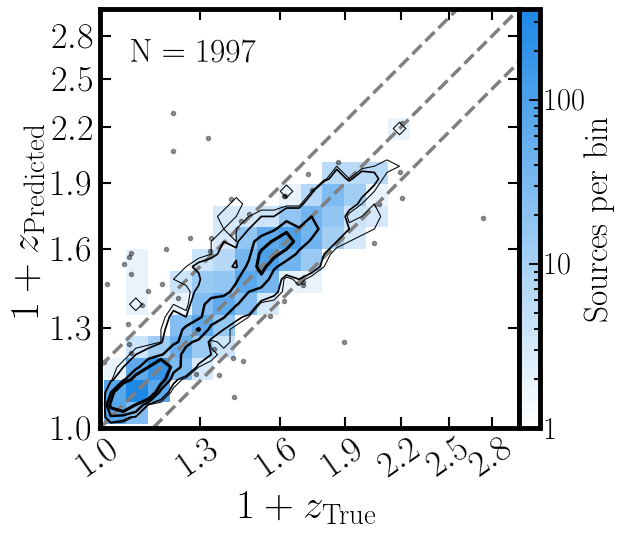

In [100]:
fig                = plt.figure(figsize=(6.5, 5.25), layout='constrained')
ax1                = fig.add_subplot(111, xscale='log', yscale='log')

try:
    norm_dens = mcolors.LogNorm()
except:
    pass

CM_focus = 'rSFG'  # 'AGN', 'SFG', 'rAGN', 'rSFG'

column_x         = 'Z'
column_y         = 'pred_Z_rSFG'
column_z         = 'Prob_AGN'
filter_good_cols = filt_pred_rSFG & filt_good_true_z

dens_plot_data_x = 1 + known_catalog_df.loc[filter_good_cols, column_x].astype(np.float64)
dens_plot_data_y = 1 + known_catalog_df.loc[filter_good_cols, column_y]
dens_plot_data_z = 1 - known_catalog_df.loc[filter_good_cols, column_z]
N_sources        = np.nansum(filter_good_cols)

min_X  = np.nanmin(1 + known_catalog_df.loc[filter_good_cols, column_x])
# max_X  = np.nanmax(1 + EMU_df.loc[filter_good_cols, column_x])
min_Y  = np.nanmin(1 + known_catalog_df.loc[filter_good_cols, column_y])
# max_Y  = np.nanmax(1 + EMU_df.loc[filter_good_cols, column_y])
max_X  = np.nanmax(1 + 1.99)  # Ad-hoc limit
max_Y  = np.nanmax(1 + 1.99)  # Ad-hoc limit
n_bins = [20, 20]
bins_X_cont = np.logspace(np.log10(np.min([min_X, min_Y])), np.log10(np.max([max_X, max_Y])), int(np.floor(n_bins[0] * 1.7)))
bins_Y_cont = np.logspace(np.log10(np.min([min_X, min_Y])), np.log10(np.max([max_X, max_Y])), int(np.floor(n_bins[1] * 1.7)))
bins_X_hist = np.logspace(np.log10(np.min([min_X, min_Y])), np.log10(np.max([max_X, max_Y])), n_bins[0])
bins_Y_hist = np.logspace(np.log10(np.min([min_X, min_Y])), np.log10(np.max([max_X, max_Y])), n_bins[1])
bins_arr_cont = [bins_X_cont, bins_Y_cont]
bins_arr_hist = [bins_X_hist, bins_Y_hist]

dens_CW = gf.color_hist2d_scipy(dens_plot_data_x,
                             dens_plot_data_y,
                             dens_plot_data_z,
                             ax_tmp=ax1,
                             target_statistic='count',
                             bins=bins_arr_hist,
                             cmap=cm_grad_SFG_whi,
                             lw=0,
                             norm=norm_dens)

added_lim_up    = 0.0  # 0.049
added_lim_do    = 0.99  # 9.9e-1
# lims_x          = (added_lim_do, np.max([max_X, max_Y]) + added_lim_up)
# lims_y          = (added_lim_do, np.max([max_X, max_Y]) + added_lim_up)
lims_x          = (added_lim_do, max_X)
lims_y          = (added_lim_do, max_Y)

# sigmas_perc     = [0.39346934, 0.86466472, 0.988891]  # [0.39346934, 0.86466472, 0.988891, 0.99966454, 0.99999627]
sigmas_perc     = [0.5, 0.75, 0.95, 0.99]  # [50%, 75%, 95% of data]
outlier_number  = int(np.floor(N_sources * (1 - sigmas_perc[-1]))) # expected number of points outside last contour
nstep           = len(sigmas_perc)
seq_cont        = np.linspace(0, 1, nstep)

H_SFG, xedges_SFG, yedges_SFG = np.histogram2d(dens_plot_data_x, dens_plot_data_y,
                                               bins=bins_arr_cont, density=False)

cont_SFG = ax1.scatter([-1], [10], marker='o', edgecolor=colour_rSFG, color=colour_black,
                       s=80, label='$\mathrm{Predicted ~ rAGN}$', linewidths=2.5)

# Flatten histogram and sort by density
H_flat   = H_SFG.ravel()
H_sorted = np.sort(H_flat)[::-1]  # Sort descending
cumulative_density = np.cumsum(H_sorted) / np.sum(H_sorted)

# Find bin count thresholds for the desired percentiles
target_percentiles = np.array(sigmas_perc) * np.sum(H_SFG)
density_thresholds = []
for target in target_percentiles:
    idx = np.argmin(np.abs(cumulative_density * np.sum(H_SFG) - target))
    threshold = H_sorted[idx]
    density_thresholds.append(threshold)
density_thresholds = sorted(set(density_thresholds), reverse=True)  # Ensure unique, decreasing values

# fix probable lines not closing
H_SFG, x_centers_SFG, y_centers_SFG = gf.pad_matrix_zeros(H_SFG, xedges_SFG, yedges_SFG)

# Plot contours using the computed density thresholds
CS_SFG = ax1.contour(x_centers_SFG, y_centers_SFG, H_SFG.T,  
                     levels=density_thresholds[::-1],  
                     colors=cm_gradient_black.reversed()(seq_cont),  
                     linewidths=np.linspace(0.75, 2.25, len(sigmas_perc)), zorder=3)

# Calculate percentage levels from density thresholds
# density_percentages = [100.0 * cumulative_density[np.searchsorted(np.sort(H_flat), level)] for level in density_thresholds]
density_percentages = [100 * sigma_perc for sigma_perc in sigmas_perc]

# Identify and plot points outside contours
try:
    p_SFG = CS_SFG.get_paths()
except Exception as e:
    p_SFG = CS_SFG.collections[0].get_paths()
inside_SFG = np.full_like(dens_plot_data_x, False, dtype=bool)
for level in p_SFG:
    inside_SFG |= level.contains_points(np.column_stack((dens_plot_data_x, dens_plot_data_y)))
print(f'There are {np.sum(inside_SFG)} sources inside contours')
print(f'There are {np.sum(~inside_SFG)} sources outside contours')
print(f'It is expected to have {outlier_number} sources outside contours')
out_SFG, = ax1.plot(dens_plot_data_x.loc[~inside_SFG], dens_plot_data_y.loc[~inside_SFG],
                    marker='.', ls='None', color=colour_black, zorder=2, alpha=0.4)

num_str = f'$\mathrm{{N}} = {N_sources}$'
if N_sources / 1e4 > 1:
    num_str = f'$\mathrm{{N}} = {N_sources:,.0f}$'.replace(',', '$\,$')
ax1.annotate(num_str, xy=(0.07, 0.93), xycoords='axes fraction',
                    fontsize=24, path_effects=gf.path_white(2.5),
                    va='top', ha='left')

ax1.axline((2, 2), (3, 3), ls='--', lw=2.5, color='gray')
# Include outlier limits
ax1.axline((2 + 1, 1 + 2.529411764705882), (3 + 1, 1 + 3.7058823529411766), ls='--', lw=2.5, color='gray')
ax1.axline((2 + 1, 1 + 1.608695652173913), (3 + 1, 1 + 2.4782608695652173), ls='--', lw=2.5, color='gray')
ax1.set_xlim(lims_x)
ax1.set_ylim(lims_y)

# cbar_str = r'$\mathrm{Prob ~ AGN} \times \mathrm{Prob ~ Radio}$'
# cbar_str = r'$\mathrm{Prob ~ AGN}$'
cbar_str = r'$\mathrm{Sources ~ per ~ bin}$'
cbar = fig.colorbar(dens_CW[1], ax=ax1, pad=0.0, format=ScalarFormatter())
cbar.ax.minorticks_on()
cbar.ax.tick_params(labelsize=22)
cbar.ax.tick_params(which='major', length=8, width=1.5, direction='in', color='k')
cbar.ax.tick_params(which='minor', length=4, width=1.5, direction='in', color='k')
cbar.outline.set_linewidth(3.5)
cbar.ax.set_ylabel(cbar_str, size=24, labelpad=-1)

ax1.minorticks_on()
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=26)
# ax1.tick_params(axis='both', which='minor', labelsize=26)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$1 + z_{\mathrm{True}}$', size=30)
ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}$', size=30)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)


arr_legends = ['$\mathrm{Predicted ~ rSFG}$']
# ax1.legend([(cont_AGN, out_AGN)], arr_legends, scatterpoints=1,
#                numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)}, loc='upper left',
#            fontsize=18, title=r'$\mathrm{EMU-PS}$', title_fontsize=16)


ax1.xaxis.set_ticks(np.arange(*lims_x, 0.3))
ax1.yaxis.set_ticks(np.arange(*lims_y, 0.3))
ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%0.1f$'))
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%0.1f$'))

# ax1.xaxis.set_major_formatter(ScalarFormatter()) 
# ax1.xaxis.set_minor_formatter(ticker.NullFormatter())
ax1.xaxis.set_minor_locator(ticker.NullLocator())
ax1.yaxis.set_minor_locator(ticker.NullLocator())
ax1.tick_params(axis='x', labelrotation=35)

ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'log_true_pred_z_true_rSFG_{used_area}_{HETDEX_subset}.pdf',
                bbox_inches='tight')
plt.show()

There are 1938 sources inside contours
There are 56 sources outside contours
It is expected to have 19 sources outside contours


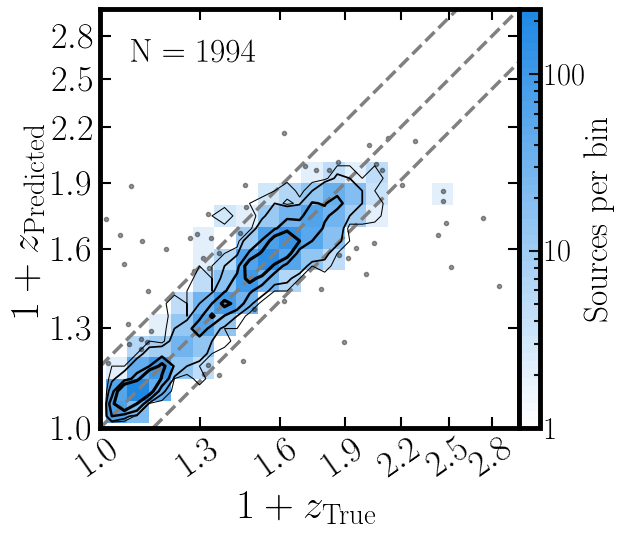

In [101]:
fig                = plt.figure(figsize=(6.5, 5.25), layout='constrained')
ax1                = fig.add_subplot(111, xscale='log', yscale='log')

try:
    norm_dens = mcolors.LogNorm()
except:
    pass

CM_focus = 'rSFG'  # 'AGN', 'SFG', 'rAGN', 'rSFG'

column_x         = 'Z'
column_y         = 'pred_Z_rSFG'
column_z         = 'Prob_AGN'
filter_good_cols = filt_true_rSFG & filt_good_true_z

dens_plot_data_x = 1 + known_catalog_df.loc[filter_good_cols, column_x].astype(np.float64)
dens_plot_data_y = 1 + known_catalog_df.loc[filter_good_cols, column_y]
dens_plot_data_z = 1 - known_catalog_df.loc[filter_good_cols, column_z]
N_sources        = np.nansum(filter_good_cols)

min_X  = np.nanmin(1 + known_catalog_df.loc[filter_good_cols, column_x])
# max_X  = np.nanmax(1 + EMU_df.loc[filter_good_cols, column_x])
min_Y  = np.nanmin(1 + known_catalog_df.loc[filter_good_cols, column_y])
# max_Y  = np.nanmax(1 + EMU_df.loc[filter_good_cols, column_y])
max_X  = np.nanmax(1 + 1.99)  # Ad-hoc limit
max_Y  = np.nanmax(1 + 1.99)  # Ad-hoc limit
n_bins = [20, 20]
bins_X_cont = np.logspace(np.log10(np.min([min_X, min_Y])), np.log10(np.max([max_X, max_Y])), int(np.floor(n_bins[0] * 1.7)))
bins_Y_cont = np.logspace(np.log10(np.min([min_X, min_Y])), np.log10(np.max([max_X, max_Y])), int(np.floor(n_bins[1] * 1.7)))
bins_X_hist = np.logspace(np.log10(np.min([min_X, min_Y])), np.log10(np.max([max_X, max_Y])), n_bins[0])
bins_Y_hist = np.logspace(np.log10(np.min([min_X, min_Y])), np.log10(np.max([max_X, max_Y])), n_bins[1])
bins_arr_cont = [bins_X_cont, bins_Y_cont]
bins_arr_hist = [bins_X_hist, bins_Y_hist]

dens_CW = gf.color_hist2d_scipy(dens_plot_data_x,
                             dens_plot_data_y,
                             dens_plot_data_z,
                             ax_tmp=ax1,
                             target_statistic='count',
                             bins=bins_arr_hist,
                             cmap=cm_grad_SFG_whi,
                             lw=0,
                             norm=norm_dens)

added_lim_up    = 0.0  # 0.049
added_lim_do    = 0.99  # 9.9e-1
# lims_x          = (added_lim_do, np.max([max_X, max_Y]) + added_lim_up)
# lims_y          = (added_lim_do, np.max([max_X, max_Y]) + added_lim_up)
lims_x          = (added_lim_do, max_X)
lims_y          = (added_lim_do, max_Y)

# sigmas_perc     = [0.39346934, 0.86466472, 0.988891]  # [0.39346934, 0.86466472, 0.988891, 0.99966454, 0.99999627]
sigmas_perc     = [0.5, 0.75, 0.95, 0.99]  # [50%, 75%, 95% of data]
outlier_number  = int(np.floor(N_sources * (1 - sigmas_perc[-1]))) # expected number of points outside last contour
nstep           = len(sigmas_perc)
seq_cont        = np.linspace(0, 1, nstep)

H_SFG, xedges_SFG, yedges_SFG = np.histogram2d(dens_plot_data_x, dens_plot_data_y,
                                               bins=bins_arr_cont, density=False)

cont_SFG = ax1.scatter([-1], [10], marker='o', edgecolor=colour_rSFG, color=colour_black,
                       s=80, label='$\mathrm{Predicted ~ rAGN}$', linewidths=2.5)

# Flatten histogram and sort by density
H_flat   = H_SFG.ravel()
H_sorted = np.sort(H_flat)[::-1]  # Sort descending
cumulative_density = np.cumsum(H_sorted) / np.sum(H_sorted)

# Find bin count thresholds for the desired percentiles
target_percentiles = np.array(sigmas_perc) * np.sum(H_SFG)
density_thresholds = []
for target in target_percentiles:
    idx = np.argmin(np.abs(cumulative_density * np.sum(H_SFG) - target))
    threshold = H_sorted[idx]
    density_thresholds.append(threshold)
density_thresholds = sorted(set(density_thresholds), reverse=True)  # Ensure unique, decreasing values

# fix probable lines not closing
H_SFG, x_centers_SFG, y_centers_SFG = gf.pad_matrix_zeros(H_SFG, xedges_SFG, yedges_SFG)

# Plot contours using the computed density thresholds
CS_SFG = ax1.contour(x_centers_SFG, y_centers_SFG, H_SFG.T,  
                     levels=density_thresholds[::-1],  
                     colors=cm_gradient_black.reversed()(seq_cont),  
                     linewidths=np.linspace(0.75, 2.25, len(sigmas_perc)), zorder=3)

# Calculate percentage levels from density thresholds
# density_percentages = [100.0 * cumulative_density[np.searchsorted(np.sort(H_flat), level)] for level in density_thresholds]
density_percentages = [100 * sigma_perc for sigma_perc in sigmas_perc]

# Identify and plot points outside contours
try:
    p_SFG = CS_SFG.get_paths()
except Exception as e:
    p_SFG = CS_SFG.collections[0].get_paths()
inside_SFG = np.full_like(dens_plot_data_x, False, dtype=bool)
for level in p_SFG:
    inside_SFG |= level.contains_points(np.column_stack((dens_plot_data_x, dens_plot_data_y)))
print(f'There are {np.sum(inside_SFG)} sources inside contours')
print(f'There are {np.sum(~inside_SFG)} sources outside contours')
print(f'It is expected to have {outlier_number} sources outside contours')
out_SFG, = ax1.plot(dens_plot_data_x.loc[~inside_SFG], dens_plot_data_y.loc[~inside_SFG],
                    marker='.', ls='None', color=colour_black, zorder=2, alpha=0.4)

num_str = f'$\mathrm{{N}} = {N_sources}$'
if N_sources / 1e4 > 1:
    num_str = f'$\mathrm{{N}} = {N_sources:,.0f}$'.replace(',', '$\,$')
ax1.annotate(num_str, xy=(0.07, 0.93), xycoords='axes fraction',
                    fontsize=24, path_effects=gf.path_white(2.5),
                    va='top', ha='left')

ax1.axline((2, 2), (3, 3), ls='--', lw=2.5, color='gray')
# Include outlier limits
ax1.axline((2 + 1, 1 + 2.529411764705882), (3 + 1, 1 + 3.7058823529411766), ls='--', lw=2.5, color='gray')
ax1.axline((2 + 1, 1 + 1.608695652173913), (3 + 1, 1 + 2.4782608695652173), ls='--', lw=2.5, color='gray')
ax1.set_xlim(lims_x)
ax1.set_ylim(lims_y)

# cbar_str = r'$\mathrm{Prob ~ AGN} \times \mathrm{Prob ~ Radio}$'
# cbar_str = r'$\mathrm{Prob ~ AGN}$'
cbar_str = r'$\mathrm{Sources ~ per ~ bin}$'
cbar = fig.colorbar(dens_CW[1], ax=ax1, pad=0.0, format=ScalarFormatter())
cbar.ax.minorticks_on()
cbar.ax.tick_params(labelsize=22)
cbar.ax.tick_params(which='major', length=8, width=1.5, direction='in', color='k')
cbar.ax.tick_params(which='minor', length=4, width=1.5, direction='in', color='k')
cbar.outline.set_linewidth(3.5)
cbar.ax.set_ylabel(cbar_str, size=24, labelpad=-1)

ax1.minorticks_on()
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=26)
# ax1.tick_params(axis='both', which='minor', labelsize=26)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$1 + z_{\mathrm{True}}$', size=30)
ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}$', size=30)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)


arr_legends = ['$\mathrm{Predicted ~ rSFG}$']
# ax1.legend([(cont_AGN, out_AGN)], arr_legends, scatterpoints=1,
#                numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)}, loc='upper left',
#            fontsize=18, title=r'$\mathrm{EMU-PS}$', title_fontsize=16)


ax1.xaxis.set_ticks(np.arange(*lims_x, 0.3))
ax1.yaxis.set_ticks(np.arange(*lims_y, 0.3))
ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%0.1f$'))
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%0.1f$'))

# ax1.xaxis.set_major_formatter(ScalarFormatter()) 
# ax1.xaxis.set_minor_formatter(ticker.NullFormatter())
ax1.xaxis.set_minor_locator(ticker.NullLocator())
ax1.yaxis.set_minor_locator(ticker.NullLocator())
ax1.tick_params(axis='x', labelrotation=35)

ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'log_true_pred_z_pred_rSFG_{used_area}_{HETDEX_subset}.pdf',
                bbox_inches='tight')
plt.show()

There are 803 sources inside contours
There are 41 sources outside contours
It is expected to have 8 sources outside contours


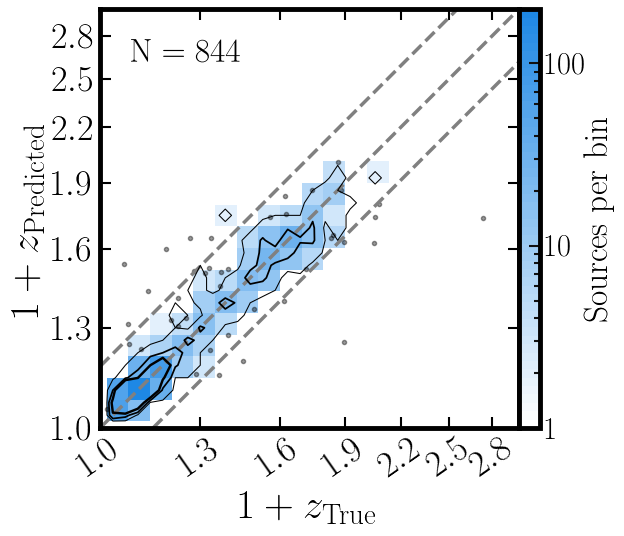

In [106]:
fig                = plt.figure(figsize=(6.5, 5.25), layout='constrained')
ax1                = fig.add_subplot(111, xscale='log', yscale='log')

try:
    norm_dens = mcolors.LogNorm()
except:
    pass

CM_focus = 'rSFG'  # 'AGN', 'SFG', 'rAGN', 'rSFG'

column_x         = 'Z'
column_y         = 'pred_Z_rSFG'
column_z         = 'Prob_AGN'
filter_good_cols = filt_true_rSFG & filt_pred_rSFG & filt_good_true_z

dens_plot_data_x = 1 + known_catalog_df.loc[filter_good_cols, column_x].astype(np.float64)
dens_plot_data_y = 1 + known_catalog_df.loc[filter_good_cols, column_y]
dens_plot_data_z = 1 - known_catalog_df.loc[filter_good_cols, column_z]
N_sources        = np.nansum(filter_good_cols)

min_X  = np.nanmin(1 + known_catalog_df.loc[filter_good_cols, column_x])
# max_X  = np.nanmax(1 + EMU_df.loc[filter_good_cols, column_x])
min_Y  = np.nanmin(1 + known_catalog_df.loc[filter_good_cols, column_y])
# max_Y  = np.nanmax(1 + EMU_df.loc[filter_good_cols, column_y])
max_X  = np.nanmax(1 + 1.99)  # Ad-hoc limit
max_Y  = np.nanmax(1 + 1.99)  # Ad-hoc limit
n_bins = [20, 20]
bins_X_cont = np.logspace(np.log10(np.min([min_X, min_Y])), np.log10(np.max([max_X, max_Y])), int(np.floor(n_bins[0] * 1.7)))
bins_Y_cont = np.logspace(np.log10(np.min([min_X, min_Y])), np.log10(np.max([max_X, max_Y])), int(np.floor(n_bins[1] * 1.7)))
bins_X_hist = np.logspace(np.log10(np.min([min_X, min_Y])), np.log10(np.max([max_X, max_Y])), n_bins[0])
bins_Y_hist = np.logspace(np.log10(np.min([min_X, min_Y])), np.log10(np.max([max_X, max_Y])), n_bins[1])
bins_arr_cont = [bins_X_cont, bins_Y_cont]
bins_arr_hist = [bins_X_hist, bins_Y_hist]

dens_CW = gf.color_hist2d_scipy(dens_plot_data_x,
                             dens_plot_data_y,
                             dens_plot_data_z,
                             ax_tmp=ax1,
                             target_statistic='count',
                             bins=bins_arr_hist,
                             cmap=cm_grad_SFG_whi,
                             lw=0,
                             norm=norm_dens)

added_lim_up    = 0.0  # 0.049
added_lim_do    = 0.99  # 9.9e-1
# lims_x          = (added_lim_do, np.max([max_X, max_Y]) + added_lim_up)
# lims_y          = (added_lim_do, np.max([max_X, max_Y]) + added_lim_up)
lims_x          = (added_lim_do, max_X)
lims_y          = (added_lim_do, max_Y)

# sigmas_perc     = [0.39346934, 0.86466472, 0.988891]  # [0.39346934, 0.86466472, 0.988891, 0.99966454, 0.99999627]
sigmas_perc     = [0.5, 0.75, 0.95, 0.99]  # [50%, 75%, 95% of data]
outlier_number  = int(np.floor(N_sources * (1 - sigmas_perc[-1]))) # expected number of points outside last contour
nstep           = len(sigmas_perc)
seq_cont        = np.linspace(0, 1, nstep)

H_SFG, xedges_SFG, yedges_SFG = np.histogram2d(dens_plot_data_x, dens_plot_data_y,
                                               bins=bins_arr_cont, density=False)

cont_SFG = ax1.scatter([-1], [10], marker='o', edgecolor=colour_rSFG, color=colour_black,
                       s=80, label='$\mathrm{Predicted ~ rAGN}$', linewidths=2.5)

# Flatten histogram and sort by density
H_flat   = H_SFG.ravel()
H_sorted = np.sort(H_flat)[::-1]  # Sort descending
cumulative_density = np.cumsum(H_sorted) / np.sum(H_sorted)

# Find bin count thresholds for the desired percentiles
target_percentiles = np.array(sigmas_perc) * np.sum(H_SFG)
density_thresholds = []
for target in target_percentiles:
    idx = np.argmin(np.abs(cumulative_density * np.sum(H_SFG) - target))
    threshold = H_sorted[idx]
    density_thresholds.append(threshold)
density_thresholds = sorted(set(density_thresholds), reverse=True)  # Ensure unique, decreasing values

# fix probable lines not closing
H_SFG, x_centers_SFG, y_centers_SFG = gf.pad_matrix_zeros(H_SFG, xedges_SFG, yedges_SFG)

# Plot contours using the computed density thresholds
CS_SFG = ax1.contour(x_centers_SFG, y_centers_SFG, H_SFG.T,  
                     levels=density_thresholds[::-1],  
                     colors=cm_gradient_black.reversed()(seq_cont),  
                     linewidths=np.linspace(0.75, 2.25, len(sigmas_perc)), zorder=3)

# Calculate percentage levels from density thresholds
# density_percentages = [100.0 * cumulative_density[np.searchsorted(np.sort(H_flat), level)] for level in density_thresholds]
density_percentages = [100 * sigma_perc for sigma_perc in sigmas_perc]

# Identify and plot points outside contours
try:
    p_SFG = CS_SFG.get_paths()
except Exception as e:
    p_SFG = CS_SFG.collections[0].get_paths()
inside_SFG = np.full_like(dens_plot_data_x, False, dtype=bool)
for level in p_SFG:
    inside_SFG |= level.contains_points(np.column_stack((dens_plot_data_x, dens_plot_data_y)))
print(f'There are {np.sum(inside_SFG)} sources inside contours')
print(f'There are {np.sum(~inside_SFG)} sources outside contours')
print(f'It is expected to have {outlier_number} sources outside contours')
out_SFG, = ax1.plot(dens_plot_data_x.loc[~inside_SFG], dens_plot_data_y.loc[~inside_SFG],
                    marker='.', ls='None', color=colour_black, zorder=2, alpha=0.4)

num_str = f'$\mathrm{{N}} = {N_sources}$'
if N_sources / 1e4 > 1:
    num_str = f'$\mathrm{{N}} = {N_sources:,.0f}$'.replace(',', '$\,$')
ax1.annotate(num_str, xy=(0.07, 0.93), xycoords='axes fraction',
                    fontsize=24, path_effects=gf.path_white(2.5),
                    va='top', ha='left')

ax1.axline((2, 2), (3, 3), ls='--', lw=2.5, color='gray')
# Include outlier limits
ax1.axline((2 + 1, 1 + 2.529411764705882), (3 + 1, 1 + 3.7058823529411766), ls='--', lw=2.5, color='gray')
ax1.axline((2 + 1, 1 + 1.608695652173913), (3 + 1, 1 + 2.4782608695652173), ls='--', lw=2.5, color='gray')
ax1.set_xlim(lims_x)
ax1.set_ylim(lims_y)

# cbar_str = r'$\mathrm{Prob ~ AGN} \times \mathrm{Prob ~ Radio}$'
# cbar_str = r'$\mathrm{Prob ~ AGN}$'
cbar_str = r'$\mathrm{Sources ~ per ~ bin}$'
cbar = fig.colorbar(dens_CW[1], ax=ax1, pad=0.0, format=ScalarFormatter())
cbar.ax.minorticks_on()
cbar.ax.tick_params(labelsize=22)
cbar.ax.tick_params(which='major', length=8, width=1.5, direction='in', color='k')
cbar.ax.tick_params(which='minor', length=4, width=1.5, direction='in', color='k')
cbar.outline.set_linewidth(3.5)
cbar.ax.set_ylabel(cbar_str, size=24, labelpad=-1)

ax1.minorticks_on()
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=26)
# ax1.tick_params(axis='both', which='minor', labelsize=26)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$1 + z_{\mathrm{True}}$', size=30)
ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}$', size=30)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)


arr_legends = ['$\mathrm{Predicted ~ rSFG}$']
# ax1.legend([(cont_AGN, out_AGN)], arr_legends, scatterpoints=1,
#                numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)}, loc='upper left',
#            fontsize=18, title=r'$\mathrm{EMU-PS}$', title_fontsize=16)


ax1.xaxis.set_ticks(np.arange(*lims_x, 0.3))
ax1.yaxis.set_ticks(np.arange(*lims_y, 0.3))
ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%0.1f$'))
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%0.1f$'))

# ax1.xaxis.set_major_formatter(ScalarFormatter()) 
# ax1.xaxis.set_minor_formatter(ticker.NullFormatter())
ax1.xaxis.set_minor_locator(ticker.NullLocator())
ax1.yaxis.set_minor_locator(ticker.NullLocator())
ax1.tick_params(axis='x', labelrotation=35)

ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'log_true_pred_z_TP_rSFG_{used_area}_{HETDEX_subset}.pdf',
                bbox_inches='tight')
plt.show()

---